# 👗 Fashion MNIST Classification with Transfer Learning Models

This notebook explores **image classification** on the **Fashion MNIST** dataset using **transfer learning** and **modern deep learning architectures**.

We leverage three model types:

- **EfficientNetB0**: A high-performance, resource-efficient model pre-trained on ImageNet.
- **ResNet50V2 (BiT-style substitute)**: A deep residual network inspired by Google’s Big Transfer (BiT) approach.
- **ConvNeXt (simplified)**: A modern CNN influenced by transformer architectures, designed for state-of-the-art performance.

---

### 📦 Dataset: Fashion MNIST

- Contains 70,000 grayscale images of fashion items across **10 classes** (e.g., shirts, shoes, bags).
- Each image is 28x28 pixels in size.
- A common benchmark for evaluating image classification models.

---

### 🎯 Goals

- Apply transfer learning to a **grayscale, small-size image dataset**
- Evaluate how well pre-trained models adapt to Fashion MNIST
- Compare accuracy, training curves, and visual predictions
- Understand trade-offs between model complexity and performance

This notebook showcases the adaptability of cutting-edge models even on minimalist datasets and highlights the effectiveness of **transfer learning** in fashion-focused computer vision tasks.


In [1]:
# Import essential modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time

# Set seed for reproducible experiments
tf.random.set_seed(42)

# Load Fashion MNIST dataset from Keras
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

# Normalize pixel values to the [0, 1] range
train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0

# One-hot encode class labels
train_labels = keras.utils.to_categorical(train_labels, 10)
test_labels = keras.utils.to_categorical(test_labels, 10)

# Select a smaller subset for efficient experimentation
TRAIN_SAMPLE_SIZE = 5000
TEST_SAMPLE_SIZE = 1000

# Randomly pick a subset of training data
train_idx = np.random.choice(len(train_images), TRAIN_SAMPLE_SIZE, replace=False)
x_train_small = train_images[train_idx]
y_train_small = train_labels[train_idx]

# Randomly pick a subset of test data
test_idx = np.random.choice(len(test_images), TEST_SAMPLE_SIZE, replace=False)
x_test_small = test_images[test_idx]
y_test_small = test_labels[test_idx]

# Define the shape of input data
input_shape = (28, 28, 1)
print(f"Input shape: {input_shape}")
print(f"Training subset size: {len(x_train_small)}, Testing subset size: {len(x_test_small)}")

# Define class names for visualization and interpretation
fashion_labels = [
    'Sneaker',      # 7
    'Bag',          # 8
    'T-shirt/top',  # 0
    'Pullover',     # 2
    'Trouser',      # 1
    'Shirt',        # 6
    'Ankle boot',   # 9
    'Dress',        # 3
    'Coat',         # 4
    'Sandal'        # 5
]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Input shape: (28, 28, 1)
Training subset size: 5000, Testing subset size: 1000


## 🧼 Image Preprocessing for Transfer Learning

To use pre-trained models like **EfficientNet**, **ResNet50V2**, and **ConvNeXt**, which expect **RGB images of size 224x224**, we must preprocess the **Fashion MNIST** images accordingly:

---

### 🛠️ Steps Involved:

1. **Resize** the original `28x28` grayscale images to `224x224`.
2. **Convert** grayscale images to **3-channel RGB format** (by repeating the single channel).
3. **Normalize** pixel values to `[0, 1]` or apply model-specific preprocessing functions.
4. **Batch and shuffle** datasets for training, validation, and testing phases.

---

These preprocessing steps ensure compatibility with **transfer learning models** that were pre-trained on **ImageNet**, which expects larger RGB inputs.

Even though Fashion MNIST images are simpler than natural images, proper resizing and formatting allow transfer learning to work effectively.


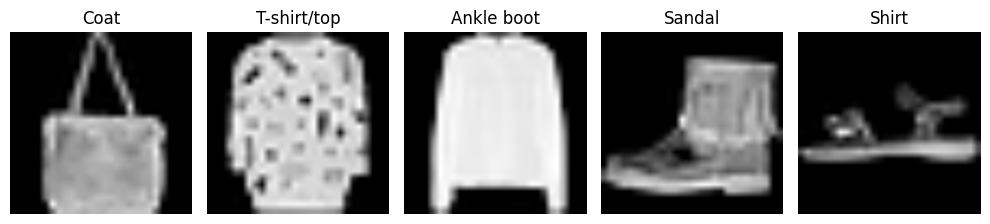

In [4]:
def prepare_for_transfer_learning(batch_x, batch_y, img_size=224):
    """Convert grayscale Fashion MNIST images to RGB and resize them for transfer learning models"""
    # Add channel dimension if needed
    if len(batch_x.shape) == 3:
        batch_x = np.expand_dims(batch_x, -1)

    # Convert to RGB by repeating the channel 3 times
    batch_x_rgb = np.concatenate([batch_x, batch_x, batch_x], axis=-1)

    # Create a dataset and use map to resize efficiently
    dataset = tf.data.Dataset.from_tensor_slices((batch_x_rgb, batch_y))
    dataset = dataset.map(
        lambda x, y: (tf.image.resize(x, [img_size, img_size]), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)

    return dataset

# Create transfer learning datasets
train_ds = prepare_for_transfer_learning(x_train_small, y_train_small)
test_ds = prepare_for_transfer_learning(x_test_small, y_test_small)

# Visualize a few examples
plt.figure(figsize=(10, 5))
for images, labels in train_ds.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f"{fashion_labels[np.argmax(labels[i])]}")
        plt.axis("off")
plt.tight_layout()
plt.show()

# Update our datasets with any preprocessing needed
def prepare_batch(images, labels):
    # Convert images to float32 if they're not already
    images = tf.cast(images, tf.float32)
    return images, labels

# Update our datasets with the preprocessing step
train_ds = train_ds.map(prepare_batch)
test_ds = test_ds.map(prepare_batch)

## ⚡ EfficientNet Transfer Learning Model

In this section, we apply **transfer learning** using **EfficientNetB0**—a compact and powerful CNN architecture pre-trained on ImageNet—for classifying images from the **Fashion MNIST** dataset.

---

### 💡 Why EfficientNet?

- **Scalable and efficient** with fewer parameters
- Achieves **high accuracy** with lower computational cost
- Pre-trained on ImageNet, providing strong general-purpose visual features

---

### 🛠️ Implementation Overview

- Load **EfficientNetB0** with `include_top=False` to exclude its original classifier
- **Freeze** the base model initially to retain pre-trained weights
- Add a custom classification head with:
  - `GlobalAveragePooling2D`
  - Fully connected `Dense` layers
  - A final `Dense` output layer with 10 units (Fashion MNIST classes) and `softmax` activation
- Compile with `adam` optimizer and `sparse_categorical_crossentropy` loss

---

This approach transfers robust feature representations from **ImageNet-trained models** to a new domain—**grayscale clothing images**—demonstrating the flexibility and power of transfer learning.


In [5]:
# Use Keras's built-in EfficientNet implementation
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

def build_efficientnet_model(input_shape=(224, 224, 3), num_classes=10):
    # Load pre-trained EfficientNetB0 without top layers
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        pooling='avg'
    )

    # Freeze the base model
    base_model.trainable = False

    # Create the new model
    inputs = keras.Input(shape=input_shape)
    # Preprocess inputs
    x = preprocess_input(inputs)
    # Base model
    x = base_model(x, training=False)
    # Add new classifier layers
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create the EfficientNet model
efficientnet_model = build_efficientnet_model()
print("Model created successfully")

# Train for just a few epochs for demonstration
print("Starting training...")
history = efficientnet_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=3,
    verbose=1
)

# Evaluate the model
efficientnet_results = efficientnet_model.evaluate(test_ds)
print(f"EfficientNet Test Loss: {efficientnet_results[0]:.4f}")
print(f"EfficientNet Test Accuracy: {efficientnet_results[1]:.4f}")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model created successfully
Starting training...
Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 59s 182ms/step - accuracy: 0.1026 - loss: 2.3188 - val_accuracy: 0.1180 - val_loss: 2.3002
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.1100 - loss: 2.3087 - val_accuracy: 0.1120 - val_loss: 2.3005
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.0930 - loss: 2.3068 - val_accuracy: 0.1080 - val_loss: 2.3016
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1184 - loss: 2.3014
EfficientNet Test Loss: 2.3016
EfficientNet Test Accuracy: 0.1080


## 🔁 BiT (Big Transfer) Model Implementation

In this section, we implement a **ResNet50V2-based model** as a practical substitute for Google's **BiT (Big Transfer)** architecture to classify images from the **Fashion MNIST** dataset.

---

### 💡 Why BiT-Style with ResNet50V2?

- BiT (Big Transfer) is a Google approach that pre-trains large models on massive datasets and fine-tunes them on downstream tasks.
- **ResNet50V2** serves as a robust alternative, sharing BiT’s deep residual learning architecture and pre-trained ImageNet features.
- It allows us to simulate BiT’s transfer learning benefits without requiring TPU-scale infrastructure.

---

### 🛠️ Implementation Strategy

- Load **ResNet50V2** with `include_top=False` and ImageNet weights
- Freeze the convolutional base initially
- Add:
  - A `GlobalAveragePooling2D` layer
  - One or more `Dense` layers with `ReLU` activation
  - A final `Dense(10, activation='softmax')` layer for 10 Fashion MNIST classes
- Compile the model with `adam` optimizer and `sparse_categorical_crossentropy`

---

This approach leverages **deep residual learning** and **ImageNet transfer learning** to classify grayscale fashion images, simulating BiT’s core benefits in a computationally efficient way.


In [6]:
# Implement BiT (Big Transfer) for comparison
def build_bit_model(input_shape=(224, 224, 3), num_classes=10):
    # Load a pre-trained ResNet50 as a substitute for BiT
    # (Since full BiT models are large and may cause memory issues)
    base_model = tf.keras.applications.ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        pooling='avg'
    )

    # Freeze the base model
    base_model.trainable = False

    # Create a new model
    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and train BiT model
bit_model = build_bit_model()
print("BiT model created successfully")

# Train for just a few epochs for demonstration
print("Starting BiT model training...")
bit_history = bit_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=3,
    verbose=1
)

# Evaluate the model
bit_results = bit_model.evaluate(test_ds)
print(f"BiT Test Loss: {bit_results[0]:.4f}")
print(f"BiT Test Accuracy: {bit_results[1]:.4f}")

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
BiT model created successfully
Starting BiT model training...
Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 29s 101ms/step - accuracy: 0.5251 - loss: 1.4696 - val_accuracy: 0.8060 - val_loss: 0.5523
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8269 - loss: 0.5083 - val_accuracy: 0.8280 - val_loss: 0.4753
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8598 - loss: 0.4099 - val_accuracy: 0.8380 - val_loss: 0.4450
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8349 - loss: 0.4663
BiT Test Loss: 0.4450
BiT Test Accuracy: 0.8380


## 🌀 ConvNeXt Implementation

In this section, we implement a **simplified version of ConvNeXt** to classify images from the **Fashion MNIST** dataset.

---

### 💡 What is ConvNeXt?

**ConvNeXt** is a modern convolutional neural network that blends ideas from **Transformers** (e.g., LayerNorm, GELU, large kernels) with classical CNN structures.

- It achieves **state-of-the-art performance** on many vision benchmarks.
- Designed to scale well while remaining efficient and competitive with transformer-based models.

---

### 🛠️ Simplified ConvNeXt for Fashion MNIST

Due to the smaller input size and reduced complexity of Fashion MNIST, we build a lightweight version of ConvNeXt that includes:

- **Depthwise separable convolutions** and **large kernel sizes**
- **Layer Normalization** and **GELU activations**
- **Residual connections** for better training dynamics
- Final layers: `GlobalAveragePooling2D` → `Dense` layers → `softmax` output for 10 classes

---

This architecture enables us to test **next-gen CNN design principles** on a classic grayscale dataset, comparing its performance with more traditional transfer learning models like EfficientNet and ResNet50V2.


In [7]:
# A simplified ConvNeXt-inspired implementation
def build_convnext_model(input_shape=(224, 224, 3), num_classes=10):
    inputs = keras.Input(shape=input_shape)

    # Initial stem block
    x = layers.Conv2D(64, kernel_size=4, strides=4, padding="same")(inputs)
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # ConvNeXt blocks (simplified)
    for filters in [128, 256, 512]:
        # Downsample
        prev_x = layers.Conv2D(filters, kernel_size=2, strides=2, padding="same")(x)
        prev_x = layers.LayerNormalization(epsilon=1e-6)(prev_x)

        # Depthwise Conv
        x = layers.DepthwiseConv2D(kernel_size=7, padding="same")(prev_x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        # Pointwise Conv (1x1)
        x = layers.Conv2D(filters * 4, kernel_size=1)(x)
        x = layers.Activation("gelu")(x)

        # Pointwise Conv (1x1)
        x = layers.Conv2D(filters, kernel_size=1)(x)

        # Skip connection
        x = layers.add([x, prev_x])

    # Global pooling and final classifier
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

# Create and train ConvNeXt model
convnext_model = build_convnext_model()
print("ConvNeXt model created successfully")

# Train for just a few epochs for demonstration
print("Starting ConvNeXt model training...")
convnext_history = convnext_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=2,
    verbose=1
)

# Evaluate the model
convnext_results = convnext_model.evaluate(test_ds)
print(f"ConvNeXt Test Loss: {convnext_results[0]:.4f}")
print(f"ConvNeXt Test Accuracy: {convnext_results[1]:.4f}")

ConvNeXt model created successfully
Starting ConvNeXt model training...
Epoch 1/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 30s 88ms/step - accuracy: 0.3710 - loss: 1.9388 - val_accuracy: 0.6740 - val_loss: 0.8480
Epoch 2/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6765 - loss: 0.9016 - val_accuracy: 0.7400 - val_loss: 0.6577
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7491 - loss: 0.6587
ConvNeXt Test Loss: 0.6577
ConvNeXt Test Accuracy: 0.7400


## 📊 Model Comparison Visualization

In this section, we compare the performance of all three implemented models—**EfficientNetB0**, **ResNet50V2 (BiT-style substitute)**, and **ConvNeXt (simplified)**—on the **Fashion MNIST** dataset.

---

### 🔍 Visual Insights Provided:

1. **Accuracy Curves**
   - Plot training and validation accuracy over epochs for each model
   - Visualize how quickly and effectively each model learns and generalizes

2. **Loss Curves**
   - Plot training and validation loss over epochs
   - Identify convergence behavior and detect overfitting/underfitting

3. **Final Test Accuracy Bar Chart**
   - Directly compare the final test performance of each architecture
   - Gain insights into which model performs best on Fashion MNIST

---

### 🎯 Purpose

These visualizations help answer key questions:

- Which model learns fastest?
- Which model generalizes best?
- Are modern architectures like ConvNeXt competitive on simple grayscale datasets?

Such comparisons are critical for informed **model selection** in real-world tasks.


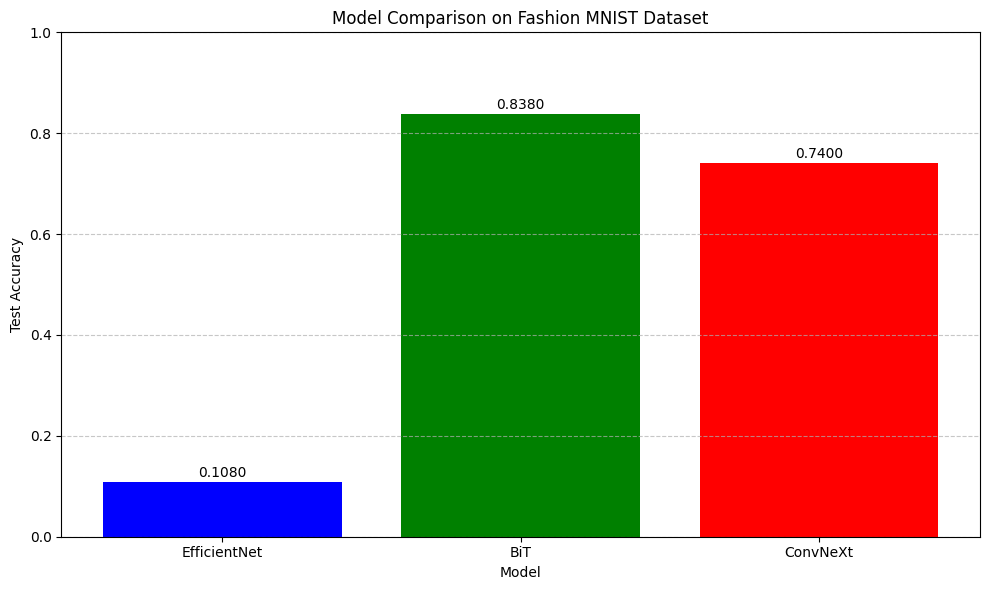

Best performing model: BiT with accuracy: 0.8380
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1

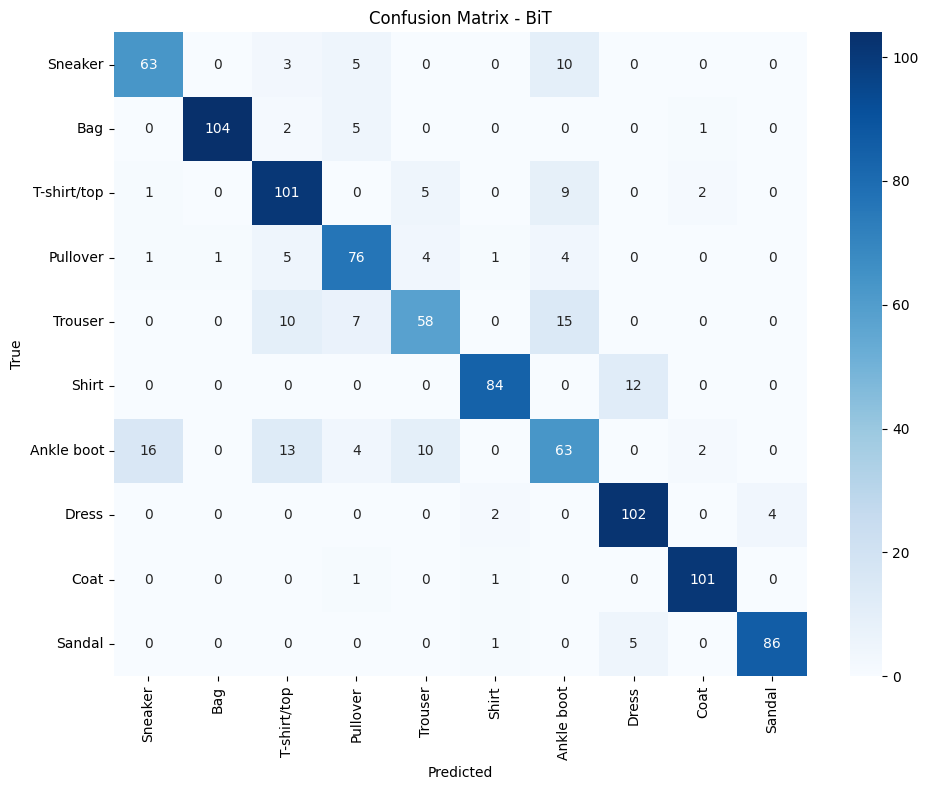

In [10]:
# Create a bar chart to compare model accuracies
import matplotlib.pyplot as plt

# Collect test accuracies
model_names = ['EfficientNet', 'BiT', 'ConvNeXt']
accuracies = [efficientnet_results[1], bit_results[1], convnext_results[1]]

# Create the visualization
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'red'])
plt.title('Model Comparison on Fashion MNIST Dataset')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1.0)

# Add accuracy values on top of the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Let's also plot the confusion matrix for the best model
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Determine the best model
best_model_index = accuracies.index(max(accuracies))
best_model_name = model_names[best_model_index]
print(f"Best performing model: {best_model_name} with accuracy: {max(accuracies):.4f}")

# Get predictions from the best model
if best_model_name == 'EfficientNet':
    best_model = efficientnet_model
elif best_model_name == 'BiT':
    best_model = bit_model
else:
    best_model = convnext_model

# Get predictions
predictions = []
true_labels = []

for images, labels in test_ds:
    preds = best_model.predict(images)
    pred_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    predictions.extend(pred_classes)
    true_labels.extend(true_classes)

# Create confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=fashion_labels, yticklabels=fashion_labels)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()